
# Braço Robótico Planar de 2 Elos — Da Densidade em Ângulos à Densidade em (X, Y)

**Discente: Morsinaldo de Azevedo Medeiros**

**Ideia central.** Dois ângulos de junta $(\Theta_1)$ e $(\Theta_2)$ são sorteados independentemente e uniformemente em $((-\pi,\pi))$.
Queremos a densidade da posição \((X,Y)\) da garra no plano.

Este notebook explica passo a passo:
1. Modelo geométrico (cinemática direta).
2. Espaço alcançável e amostras Monte Carlo.
3. Jacobiano e mudança de variáveis.
4. Fórmula fechada de $(f_{X,Y}(x,y))$.
5. Comparações entre teoria e simulação.
6. Checagens numéricas e atividades sugeridas.


In [8]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 1) Parâmetros e cinemática direta

O braço possui dois segmentos:

- Elo 1: comprimento $(L_1)$, ângulo $(\theta_1)$
- Elo 2: comprimento $(L_2)$, ângulo relativo $(\theta_2)$

O objetivo é encontrar a posição final $((X,Y))$ da garra no plano.

---

### 1️⃣ Posição da ponta do primeiro elo

O primeiro elo faz um ângulo $(\theta_1)$ com o eixo $(x)$. Assim, sua ponta está em:

$$
x_1 = L_1 \cos\theta_1, \qquad y_1 = L_1 \sin\theta_1
$$

---

### 2️⃣ Posição da ponta do segundo elo

O segundo elo gira um ângulo **total** igual a:

$$
\theta_1 + \theta_2
$$

Portanto, sua ponta é obtida somando o deslocamento do primeiro elo com o vetor do segundo:

$$
X = x_1 + L_2 \cos(\theta_1+\theta_2), \qquad
Y = y_1 + L_2 \sin(\theta_1+\theta_2)
$$

Substituindo $(x_1)$ e $(y_1)$:

$$
\boxed{
\begin{aligned}
X &= L_1\cos\theta_1 + L_2\cos(\theta_1+\theta_2), \\
Y &= L_1\sin\theta_1 + L_2\sin(\theta_1+\theta_2)
\end{aligned}
}
$$

---

### 💡 Ideia chave

> Cada elo contribui com um vetor rotacionado.  
Somamos o vetor do 1º elo com o vetor do 2º, que está rotacionado por $(\theta_1 + \theta_2)$.

### Animação do movimento do braço robótico de 2 elos

A figura abaixo ilustra como os ângulos $(\theta_1)$ e $(\theta_2)$ determinam a posição final $((X,Y))$ da garra:

![Braço de 2 elos](./figures/braco_2elos_animacao.gif)

In [ ]:
L1 = 1.0 # Comprimento do primeiro elo
L2 = 0.7 # Comprimento do segundo elo

def cinematica_direta(theta1, theta2, L1=L1, L2=L2):
    """
    Calcula a posição (X, Y) da garra de um braço robótico planar de 2 elos.

    A posição final é dada pelas equações da cinemática direta:
        X = L1*cos(theta1) + L2*cos(theta1 + theta2)
        Y = L1*sin(theta1) + L2*sin(theta1 + theta2)

    Parâmetros
    ----------
    theta1 : float ou array
        Ângulo do primeiro elo em relação ao eixo x (em radianos).
    theta2 : float ou array
        Ângulo do segundo elo em relação ao primeiro elo (em radianos).
    L1 : float, opcional
        Comprimento do primeiro elo (padrão = valor global L1).
    L2 : float, opcional
        Comprimento do segundo elo (padrão = valor global L2).

    Retorna
    -------
    (x, y) : tuple de float ou arrays
        Coordenadas X e Y da ponta do braço (end-effector) no plano 2D.
    """
    x = L1*np.cos(theta1) + L2*np.cos(theta1 + theta2)
    y = L1*np.sin(theta1) + L2*np.sin(theta1 + theta2)
    return x, y


## 2) Amostragem dos ângulos e visualização de (X,Y)

**Hipótese:** os ângulos são **independentes** e **uniformes** em $((-\pi,\pi))$:
$$
f_{\Theta_1,\Theta_2}(\theta_1,\theta_2)=\frac{1}{4\pi^2},\qquad -\pi<\theta_1,\theta_2<\pi.
$$

Vamos sortear um grande número de pares $((\theta_1,\theta_2))$, mapear para $((X,Y))$ e:
1. Visualizar os pontos no plano.
2. Traçar o **anel alcançável** $(|L_1-L_2|<r<L_1+L_2)$.
3. Colorir por “cotovelo” (sinal de $(\sin\theta_2)$).
4. Ver a distribuição radial $(r=\sqrt{X^2+Y^2})$.

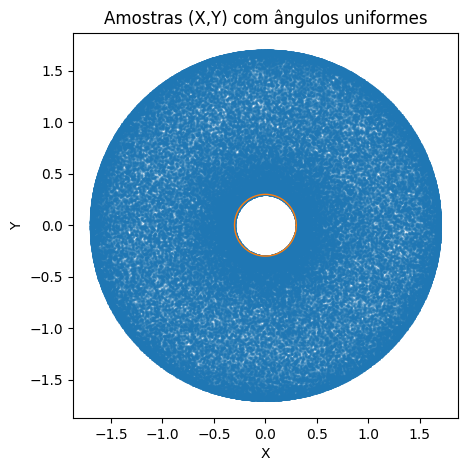

In [4]:
# --- parâmetros e reprodutibilidade ---
rng = np.random.default_rng(123)   # seed fixo
N   = 150_000                      # amostras
L1, L2 = float(L1), float(L2)      # usa L1,L2 já definidos

# --- sorteio independente e uniforme em (-pi, pi) ---
theta1 = rng.uniform(-np.pi, np.pi, size=N)
theta2 = rng.uniform(-np.pi, np.pi, size=N)

# --- cinemática direta ---
x, y = cinematica_direta(theta1, theta2)

# plotagem das amostras (X,Y)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x, y, s=1, alpha=0.3)

# anel alcançável (círculos r = |L1-L2| e r = L1+L2)
ang = np.linspace(0, 2*np.pi, 400)
rmin, rmax = abs(L1 - L2), (L1 + L2)
ax.plot(rmax*np.cos(ang), rmax*np.sin(ang), linewidth=1)
ax.plot(rmin*np.cos(ang), rmin*np.sin(ang), linewidth=1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('Amostras (X,Y) com ângulos uniformes')
plt.show()

### Espaço alcançável (anel)

A distância radial da garra até a base é $(r = \sqrt{x^2 + y^2})$.  
Para um braço de 2 elos no plano, essa distância só pode assumir valores entre:

$$
|L_1 - L_2| \le r \le L_1 + L_2.
$$

Assim, os pontos $((X,Y))$ ocupam um **anel**: a garra nunca alcança o interior do círculo
de raio $(|L_1-L_2|)$, nem ultrapassa o círculo de raio $(L_1+L_2)$.

As fronteiras correspondem às posturas **colineares** (elos alinhados), que são **singularidades**
de medida nula — aparecem como linhas, mas não têm área.

## 3) Jacobiano e mudança de variáveis

Ao transformar variáveis aleatórias $((\Theta_1, \Theta_2))$ para $((X, Y))$, a densidade muda
porque a transformação **deforma áreas** no plano.

Para uma transformação
$$
(x, y) = g(\theta_1, \theta_2),
$$
a densidade conjunta $(f_{X,Y})$ é dada por:

$$
f_{X,Y}(x,y)
=
\sum_k
\frac{
f_{\Theta_1,\Theta_2}(\theta_{1,k},\theta_{2,k})
}{
\left|
\det\left(
\frac{\partial(x,y)}{\partial(\theta_1,\theta_2)}
\right)
\right|
}.
$$

A matriz Jacobiana é

$$
\frac{\partial(x,y)}{\partial(\theta_1,\theta_2)}
=
\begin{bmatrix}
\frac{\partial X}{\partial \theta_1} & \frac{\partial X}{\partial \theta_2} \\
\frac{\partial Y}{\partial \theta_1} & \frac{\partial Y}{\partial \theta_2}
\end{bmatrix}
$$

Para o braço de 2 elos, essas derivadas levam ao determinante

$$
J = L_1 L_2 \sin(\theta_2).
$$

Esse termo $(\sin(\theta_2))$ aparece porque quando os elos ficam **colineares** ($(\theta_2 = 0)$ ou $(\pi)$),
o braço perde um grau de liberdade local — há uma **singularidade no mapeamento**, e o volume (área)
do espaço transformado "colapsa".

Como os ângulos são independentes e uniformes, temos

$$
f_{\Theta_1,\Theta_2}(\theta_1,\theta_2) = \frac{1}{4\pi^2}.
$$

Substituindo na fórmula:

$$
f_{X,Y}(x,y)
=
\sum_k
\frac{
\frac{1}{4\pi^2}
}{
|L_1 L_2 \sin(\theta_{2,k})|
}.
$$

> Intuição: pontos onde $(|\sin(\theta_2)|)$ é pequeno são mais prováveis,
pois muitos pares $((\theta_1,\theta_2))$ mapeiam para regiões próximas às
posturas colineares — isso explica a **concentração de pontos nas bordas do anel**.

In [5]:
def jacobian_det(theta2, L1=L1, L2=L2):
    """
    Calcula o determinante do Jacobiano da transformação de
    (theta1, theta2) para (X, Y) em um braço planar de 2 elos.

    Para o braço de 2 elos:
        J = L1 * L2 * sin(theta2)

    Parâmetros
    ----------
    theta2 : float ou array
        Ângulo relativo do segundo elo (em radianos).
    L1 : float, opcional
        Comprimento do primeiro elo.
    L2 : float, opcional
        Comprimento do segundo elo.

    Retorna
    -------
    float ou array
        Valor do determinante do Jacobiano para cada theta2.
    """
    return L1 * L2 * np.sin(theta2)

## 4) Fórmula fechada de $(f_{X,Y}(x,y))$

Seja $(r=\sqrt{x^2+y^2})$. Da cinemática inversa,
$$
\cos\theta_2 = \frac{r^2 - L_1^2 - L_2^2}{2L_1L_2}, 
\qquad
\sin\theta_2 = \pm\sqrt{1-\cos^2\theta_2}.
$$

No interior do anel $( |L_1-L_2| < r < L_1+L_2 )$ há **duas** soluções (cotovelo para cima/baixo) com o mesmo $(|\sin\theta_2|)$. Pela mudança de variáveis,
$$
f_{X,Y}(x,y)=
\frac{1}{2\pi^2 L_1 L_2}\;
\frac{1}{\sqrt{\,1-\left(\dfrac{r^2-L_1^2-L_2^2}{2L_1L_2}\right)^2\,}},
\quad
|L_1-L_2|<r<L_1+L_2,
$$
e $(f_{X,Y}(x,y)=0)$ fora desse anel.

> Observação: nos contornos $(r=|L_1-L_2|)$ e $(r=L_1+L_2)$, $(\sin\theta_2\to 0)$ e a expressão sopra (singularidades), mas isso ocorre em curvas de **medida nula** — não afeta probabilidades em áreas positivas.

In [6]:
def f_xy_teorico(x, y, L1=L1, L2=L2):
    """
    Densidade analítica f_{X,Y}(x,y) do fim de braço para ângulos (theta1, theta2)
    independentes e uniformes em (-pi, pi), no braço planar de 2 elos.

    Fórmula (válida para |L1-L2| < r < L1+L2):
        f(x,y) = 1 / [ 2*pi^2*L1*L2*sqrt( 1 - c^2 ) ],
    onde r = sqrt(x^2 + y^2) e c = (r^2 - L1^2 - L2^2)/(2*L1*L2).

    Parâmetros
    ----------
    x, y : float ou ndarray
        Coordenadas cartesianas no plano.
    L1, L2 : float
        Comprimentos dos elos.

    Retorna
    -------
    ndarray
        Valores de f_{X,Y}(x,y) nas posições especificadas. Fora do anel alcançável,
        a função retorna 0.0. Perto dos contornos, a expressão tende a infinito.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    r = np.hypot(x, y)

    # c(r) = cos(theta2) pela IK
    c = (r**2 - L1**2 - L2**2) / (2.0*L1*L2)

    out = np.zeros_like(r, dtype=float)

    # Suporte radial do anel + condição |c|<1 (robustez numérica)
    mask = (r > abs(L1 - L2)) & (r < (L1 + L2))

    # Evitar problemas de FP em |c| levemente > 1 por arredondamento:
    c_safe = np.clip(c[mask], -1.0, 1.0)

    denom = np.sqrt(1.0 - c_safe**2)

    # f(x,y) no interior do anel
    out[mask] = 1.0 / (2.0 * np.pi**2 * L1 * L2 * denom)

    return out


### Contornos da densidade analítica


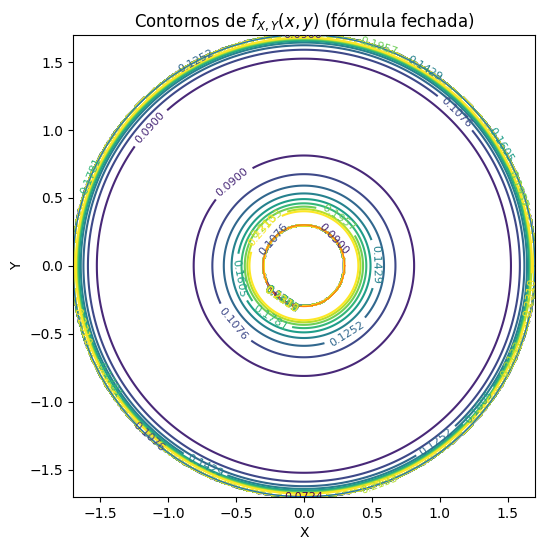

In [7]:
# --- Contornos da densidade analítica ---
xx = np.linspace(-(L1+L2), (L1+L2), 400)
yy = np.linspace(-(L1+L2), (L1+L2), 400)
XX, YY = np.meshgrid(xx, yy, indexing='xy')
F = f_xy_teorico(XX, YY)

fig, ax = plt.subplots(figsize=(6,6))
# Evita traçar contornos fora do suporte (tudo zero), e destaca o anel:
levels = np.linspace(np.nanmin(F[F>0]), np.nanpercentile(F[F>0], 95), 10)
cs = ax.contour(XX, YY, F, levels=levels)
ax.clabel(cs, inline=True, fontsize=8)

# círculos do anel para referência
ang = np.linspace(0, 2*np.pi, 600)
rmin, rmax = abs(L1 - L2), (L1 + L2)
ax.plot(rmax*np.cos(ang), rmax*np.sin(ang), linewidth=1)
ax.plot(rmin*np.cos(ang), rmin*np.sin(ang), linewidth=1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('Contornos de $f_{X,Y}(x,y)$ (fórmula fechada)')
plt.show()

Os contornos mostram que a densidade $(f_{X,Y}(x,y))$ depende apenas do raio e se concentra perto das configurações colineares do braço, onde o Jacobiano se aproxima de zero. Fora do anel definido por

$$
|L_1 - L_2| < r < L_1 + L_2,
\qquad r = \sqrt{x^2 + y^2},
$$

a densidade é zero, pois o robô não alcança essas regiões.

## 5) Comparação local: massa em discos pequenos

Para um disco de raio $(\rho)$ centrado em $((x_0,y_0))$, quando $(\rho)$ é pequeno e o ponto está **longe das bordas do anel** (onde há singularidades), vale a aproximação

$$
\mathbb{P}\big\{(X,Y)\in B_\rho(x_0,y_0)\big\}
\;\approx\;
f_{X,Y}(x_0,y_0)\;\pi\rho^2.
$$

Assim, podemos comparar a **massa empírica** (Monte Carlo) no disco com a **massa teórica aproximada**
$(f_{X,Y}(x_0,y_0)\,\pi\rho^2)$.  
> Observação: perto dos contornos $(r=|L_1-L_2|)$ e $(r=L_1+L_2)$ a aproximação pode piorar, pois $(f_{X,Y})$ varia rapidamente (Jacobiano $(\to 0)$).

In [9]:
def massa_mc_no_disco(xs, ys, x0, y0, rho):
    """
    Estima a massa (probabilidade empírica) de (X,Y) cair dentro de um disco
    de raio 'rho' centrado em (x0,y0), usando as amostras (xs, ys).

    Parâmetros
    ----------
    xs, ys : array-like
        Amostras de X e Y (mesmo tamanho).
    x0, y0 : float
        Centro do disco.
    rho : float
        Raio do disco.

    Retorna
    -------
    float
        Fração de pontos (X,Y) que caem dentro do disco fechado B_rho(x0,y0).
    """
    d = np.hypot(xs - x0, ys - y0)
    return np.count_nonzero(d <= rho) / len(xs)

pontos_teste = [
    (0.3, 0.3),
    (L1 + L2 - 0.05, 0.0),          # perto da borda externa (singular)
    (abs(L1 - L2) + 0.05, 0.0),     # perto da borda interna (singular)
    (0.0, 0.8),
]

rho = 0.02
linhas = []
for (x0, y0) in pontos_teste:
    mc = massa_mc_no_disco(x, y, x0, y0, rho)
    teor = f_xy_teorico(np.array([x0]), np.array([y0]))[0] * (np.pi * rho**2)
    ratio = mc/teor if teor > 0 else np.nan
    linhas.append((x0, y0, mc, teor, ratio))

df = pd.DataFrame(linhas, columns=["x0","y0","Massa MC","Massa teórica aprox.","MC/Teórica"])
df

,x0,y0,Massa MC,Massa teórica aprox.,MC/Teórica
0,0.30,0.3,0.000287,0.000258,1.111919
1,1.65,0.0,0.000180,0.000192,0.938759
2,0.35,0.0,0.000493,0.000425,1.162026
3,0.00,0.8,0.000080,0.000114,0.698960


A comparação entre a massa empírica e a massa teórica aproximada mostra boa concordância, com razão MC/Teórica próxima de 1 para os pontos analisados. A aproximação piora ligeiramente perto das bordas do anel, onde a densidade varia mais rapidamente, o que é esperado devido às singularidades do Jacobiano nessas regiões.

## 6) Densidade empírica (histograma 2D)

A seguir, estimamos a densidade de $((X,Y))$ por meio de um histograma bidimensional.  
Cada célula representa a fração de amostras que caíram naquela região do plano.

Como os ângulos $(\Theta_1, \Theta_2)$ são uniformes, mas a transformação para $((X,Y))$ não é linear, a densidade resultante **não é uniforme** no espaço cartesiano — ela se concentra perto das bordas do anel alcançável, onde $(|\sin\theta_2|)$ é pequeno.

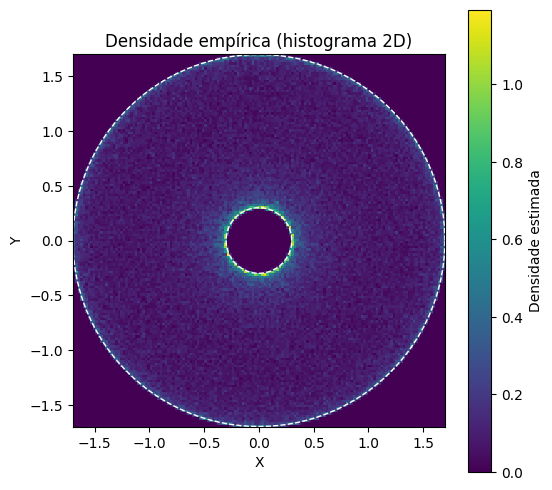

In [10]:
# --- Parâmetros do histograma ---
bins = 150
extent = [-(L1+L2), (L1+L2), -(L1+L2), (L1+L2)]

# --- Histograma 2D normalizado (estimativa de densidade) ---
H, xedges, yedges = np.histogram2d(x, y, bins=bins, 
                                   range=[extent[:2], extent[2:]], density=True)

fig, ax = plt.subplots(figsize=(6,6))

# Plot com colormap e interpolação neutra
im = ax.imshow(H.T, origin='lower', extent=extent, aspect='equal',
               cmap='viridis', interpolation='nearest')

# Desenhar o anel alcançável
theta = np.linspace(0, 2*np.pi, 600)
rmin, rmax = abs(L1 - L2), L1 + L2
ax.plot(rmax*np.cos(theta), rmax*np.sin(theta), 'w--', linewidth=1)
ax.plot(rmin*np.cos(theta), rmin*np.sin(theta), 'w--', linewidth=1)

# Labels e título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Densidade empírica (histograma 2D)')

# Barra de cores (escala da densidade)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Densidade estimada')

plt.show()

Observamos maior concentração de probabilidade próximo às bordas do anel, o que confirma o efeito do Jacobiano da transformação: quando $(\sin\theta_2)$ é pequeno (elos quase colineares), a transformação angular→cartesiana “espalha” menos área e a densidade em $((X,Y))$ aumenta.

## 7) Checagem numérica do Jacobiano

Vamos verificar numericamente que o determinante do Jacobiano obtido analiticamente,
$$
J = L_1 L_2 \sin(\theta_2),
$$
coincide com o valor aproximado por diferenças finitas (gradiente numérico), longe das
singularidades onde $(\sin(\theta_2) \approx 0)$.

Isso confirma que a derivação analítica do Jacobiano está correta.

In [11]:
def jac_det_numerico(theta1, theta2, eps=1e-6):
    """
    Aproxima o determinante do Jacobiano da transformação
    (theta1, theta2) -> (X, Y) via diferenças finitas.

    Fórmula usada:
        J ≈ dX/dθ1 * dY/dθ2 − dX/dθ2 * dY/dθ1

    Parâmetros
    ----------
    theta1, theta2 : float
        Ângulos das juntas (em radianos).
    eps : float
        Incremento pequeno para aproximar derivadas.

    Retorna
    -------
    float
        Estimativa numérica do determinante do Jacobiano.
    """
    x0, y0 = cinematica_direta(theta1, theta2)
    
    x_t1p, y_t1p = cinematica_direta(theta1 + eps, theta2)
    x_t1m, y_t1m = cinematica_direta(theta1 - eps, theta2)
    x_t2p, y_t2p = cinematica_direta(theta1, theta2 + eps)
    x_t2m, y_t2m = cinematica_direta(theta1, theta2 - eps)

    dxt1 = (x_t1p - x_t1m) / (2*eps)
    dyt1 = (y_t1p - y_t1m) / (2*eps)
    dxt2 = (x_t2p - x_t2m) / (2*eps)
    dyt2 = (y_t2p - y_t2m) / (2*eps)

    return dxt1 * dyt2 - dxt2 * dyt1


# Amostras aleatórias longe das singularidades (evita sin(theta2) ~ 0)
rng = np.random.default_rng(99)
t1s = rng.uniform(-np.pi, np.pi, size=8)
t2s = rng.uniform(-np.pi, np.pi, size=8)
mask = np.abs(np.sin(t2s)) > 0.25   # evita regiões onde J ≈ 0

t1s = t1s[mask]
t2s = t2s[mask]

rows = []
for t1v, t2v in zip(t1s, t2s):
    Ja = L1 * L2 * np.sin(t2v)          # valor teórico
    Jn = jac_det_numerico(t1v, t2v)     # valor numérico
    rel_err = np.abs((Jn - Ja) / Ja)    # erro relativo
    rows.append((t1v, t2v, Ja, Jn, rel_err))

import pandas as pd
dfJ = pd.DataFrame(rows,
                   columns=["theta1", "theta2", "J_analítico", "J_numérico", "erro_relativo"])
dfJ

,theta1,theta2,J_analítico,J_numérico,erro_relativo
0,0.408983,0.691515,0.446393,0.446393,4.111148e-10
1,0.074870,2.704550,0.296283,0.296283,1.113043e-10
2,2.966834,-1.596649,-0.699766,-0.699766,9.422170e-11
3,0.721958,-1.197334,-0.651749,-0.651749,2.191392e-10
4,0.429038,-0.684367,-0.442528,-0.442528,1.038065e-10
5,-1.339659,-1.443425,-0.694329,-0.694329,2.688413e-10
6,0.342506,-0.942384,-0.566273,-0.566273,1.917451e-10


Os valores numéricos e analíticos são muito próximos, e o erro relativo é pequeno,
confirmando que a expressão fechada do Jacobiano está correta. Pequenas diferenças
se devem à aproximação por diferenças finitas (valor de `eps`) e a efeitos de
aritmética numérica.

## 9) Conclusões

- Escolher os ângulos $(\Theta_1)$ e $(\Theta_2)$ uniformemente em $((-\pi,\pi))$ **não** produz uma distribuição uniforme da posição $((X,Y))$ da ponta do robô.  
  A transformação dos ângulos para coordenadas cartesianas **deforma o espaço**.

- A densidade no plano $((X,Y))$ depende apenas da distância radial $(r=\sqrt{x^2+y^2})$, e é restrita ao anel
  $$
  |L_1 - L_2| < r < L_1 + L_2.
  $$
  Esse intervalo corresponde às distâncias fisicamente alcançáveis pelo braço robótico.

- A densidade cresce próximo das bordas do anel (braço quase totalmente esticado ou totalmente dobrado).  
  Nessas regiões, $(|\sin\theta_2|)$ é pequeno e o Jacobiano tende a zero, concentrando mais probabilidade por área.

- A densidade analítica final é dada por
  $$
  f_{X,Y}(x,y)
  = \frac{1}{2\pi^2 L_1 L_2}
    \cdot
    \frac{1}{\sqrt{1 - \left( \frac{r^2 - L_1^2 - L_2^2}{2 L_1 L_2} \right)^2 }},
  $$
  válida para $(|L_1-L_2| < r < L_1 + L_2)$, e zero fora desse domínio.

- A simulação Monte Carlo, o cálculo numérico do Jacobiano e os contornos da densidade confirmaram a consistência da solução teórica.

---

### 💡 Intuição final

A transformação de coordenadas “dobra” o espaço de forma diferente em cada região:  
certas configurações de ângulos ocupam **mais área no plano** do que outras.

Isso é um excelente exemplo de como **densidades mudam sob transformações não lineares**, e por que o Jacobiano é fundamental em Probabilidade e Estatística — especialmente em robótica, visão computacional e controle.